In [1]:
!python --version

Python 3.8.8


### Imports

In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import PIL
from PIL import Image,UnidentifiedImageError,ImageFile

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
import cv2 as cv

from keras.preprocessing.image import load_img,img_to_array,array_to_img
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,Activation
from keras.models import save_model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.models import Model
from keras import layers

print(tf.__version__)

2.4.1


#### Image Pre-processing

In [3]:
Image.MAX_IMAGE_PIXELS = 933120000
IMG_SIZE = (50,50)
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Dataset Paths

In [4]:
# DATASET PATHS
DATASET_DIR = Path('NEW_DATASET_10')

# Setting Up Directories

# TRAIN DATA PATH
TRAIN_CSV_PATH = os.path.join(DATASET_DIR,'TRAIN','multimodal_train.csv')
TRAIN_IMG_PATH = os.path.join(DATASET_DIR,'TRAIN','IMAGES')

# TEST DATA PATH
TEST_CSV_PATH = os.path.join(DATASET_DIR,'TEST','multimodal_test.csv')
TEST_IMG_PATH = os.path.join(DATASET_DIR,'TEST','IMAGES')

# VALIDATE DATA PATH
VALIDATE_CSV_PATH = os.path.join(DATASET_DIR,'VALIDATE','multimodal_validate.csv')
VALIDATE_IMG_PATH = os.path.join(DATASET_DIR,'VALIDATE','IMAGES')

# PRE_PROCESSED DATA PATHS
PRE_PROCESSED_TRAIN_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','train_data.npz')
PRE_PROCESSED_TEST_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','test_data.npz')
PRE_PROCESSED_VALIDATE_DATA_PATH = os.path.join(DATASET_DIR,'PROCESSED_DATA','validate_data.npz')

# Model Outputs
MODEL_OUTPUT_DIR = Path('Model_Outputs')

In [5]:
train_df = pd.read_csv(TRAIN_CSV_PATH,low_memory=False)
validate_df = pd.read_csv(VALIDATE_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

In [6]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)
validate_df = shuffle(validate_df)

In [7]:
def append_ext(fn):
    return fn+".jpg"
train_df["id"]=train_df["id"].apply(append_ext)
validate_df["id"]=validate_df["id"].apply(append_ext)
test_df['id']=test_df['id'].apply(append_ext)

In [8]:
train_df[['id','clean_title','2_way_label']].head()

,id,clean_title,2_way_label
2992,bomeuc.jpg,my works water fountain drain looks like a wif...,1
16812,c7foc6.jpg,my refrigerators ice maker has a sabbath mode,1
20451,9jegme.jpg,a man passed my work today in his wheelchair b...,1
21159,39l921.jpg,hieronymus bosch painted sheet music on a mans...,1
10009,bzhc0e.jpg,this key is in the shape of a wrench,1


In [9]:
def _isImgCorrupted(img):
    try:
        im = Image.open(img)
        im.verify()
        return False
 
    except FileNotFoundError:
        return True
    
    except SyntaxError:
        return True
    
    except PIL.UnidentifiedImageError:
        return True

In [10]:
def check_remove_corrupted_images(df,IMG_PATH):
    corruptCount = 0
    temp_df = df[['id','2_way_label']]
    for i,row in temp_df.iterrows():
        img,_ = row.tolist()
        impath = os.path.join(IMG_PATH,img)
        try:
            if _isImgCorrupted(impath):
                print(i,img)
                df = df.drop(i)
                corruptCount += 1
        
        except Exception as e:
            print(f'Error in {img} : {e}')
            # sys.exit(0)
    print(f'Removed {corruptCount} corrupted images.')
    return df

In [11]:
def preprocess_image_data(df,IMG_PATH):
    X = []
    y = []
    temp_df = df[['id','2_way_label']]
    for i,row in temp_df.iterrows():
        img,label = row.tolist()
        impath = os.path.join(IMG_PATH,img)
        try:
            im = load_img(impath,target_size=IMG_SIZE)
            img_array = img_to_array(im)
            X.append(img_array)
            y.append(label)

        except Exception as e:
            print(f'{img}: {e}')
    
    X = np.array(X)
    y = np.array(y)

    X = X / 255.0

    return (X,y)

In [12]:
train_df = check_remove_corrupted_images(train_df,TRAIN_IMG_PATH)
test_df = check_remove_corrupted_images(test_df,TEST_IMG_PATH)
validate_df = check_remove_corrupted_images(validate_df,VALIDATE_IMG_PATH)

43944 ds6txmd.jpg
32504 c82xgjo.jpg
52462 cfgh9p6.jpg
33348 d0z4kl2.jpg
37428 c8frys7.jpg
49288 csb9lwl.jpg
37369 cafzidr.jpg
39277 dsqptd5.jpg
48604 c89m77i.jpg
45643 c5qkhy6.jpg
33653 drslqwx.jpg
36308 cm2petz.jpg
56044 c76o894.jpg
48986 ca9ko4d.jpg
36040 dn406w7.jpg
36180 c9t9efu.jpg
39597 cmcpahb.jpg
35840 cqh3dwe.jpg
31102 cbyr0zz.jpg
39220 cn6693m.jpg
37920 dcp93kl.jpg
39432 f3snfue.jpg
48146 euf4y6i.jpg
56150 dhig0jf.jpg
52854 chmlqm2.jpg
43659 d0t4oap.jpg
56321 e5a0irs.jpg
55192 ddj7mjf.jpg
49619 c4uolqt.jpg
37981 c8uqsjg.jpg
36300 corzta4.jpg
42369 cea9g9y.jpg
34859 csjp1ca.jpg
51152 cdekcw4.jpg
36063 f2zd5yw.jpg
30400 f3704pg.jpg
Removed 36 corrupted images.
4711 c7nbduy.jpg
4123 cac53b8.jpg
4646 dhmh8hc.jpg
Removed 3 corrupted images.
5084 ctlphvf.jpg
3808 c89rc9d.jpg
3018 cmk2pxb.jpg
Removed 3 corrupted images.


In [13]:
X_train_img, y_train_img = preprocess_image_data(train_df,TRAIN_IMG_PATH)
X_train_img.shape , y_train_img.shape

C:\Users\fharookshaik\AppData\Local\Programs\Python\Python38\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


((56364, 50, 50, 3), (56364,))

In [14]:
array_to_img(X_train_img[0])
X_train_img.shape[1:]

(50, 50, 3)

In [15]:
X_val_img,y_val_img = preprocess_image_data(validate_df,VALIDATE_IMG_PATH)
X_val_img.shape, y_val_img.shape

((5931, 50, 50, 3), (5931,))

In [16]:
train_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'author', 'clean_title', 'created_utc',
       'domain', 'hasImage', 'id', 'image_url', 'linked_submission_id',
       'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio',
       '2_way_label', '3_way_label', '6_way_label'],
      dtype='object')

In [17]:
# datagen = ImageDataGenerator(rescale=1./255,
#                              rotation_range=30,
#                              width_shift_range=0.2,
#                              height_shift_range=0.2,
#                              zoom_range=0.3)

# train_generator = datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory=TRAIN_IMG_PATH,
#     x_col='id',
#     y_col='2_way_label',
#     class_mode='raw',
#     target_size=IMG_SIZE,
#     batch_size=32
# )

# valid_generator = datagen.flow_from_dataframe(
#     dataframe=validate_df,
#     directory=VALIDATE_IMG_PATH,
#     x_col='id',
#     y_col='2_way_label',
#     class_mode='raw',
#     target_size=IMG_SIZE,
#     batch_size=32
# )

#### Text Pre-processing

In [18]:
X_train_text = train_df.iloc[:,3].values
y_train_text = train_df.iloc[:,15].values
X_train_text.shape, y_train_text.shape

((56364,), (56364,))

In [19]:
X_val_text = validate_df.iloc[:,3].values
y_val_text = validate_df.iloc[:,15].values
X_val_text.shape, y_val_text.shape

((5931,), (5931,))

In [20]:
X_test_text = test_df.iloc[:,3].values
y_test_text = test_df.iloc[:,15].values
X_test_text.shape, y_test_text.shape

((5927,), (5927,))

In [21]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [22]:
tk = Tokenizer(num_words=1000,filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True,split=" ")
tk.fit_on_texts(X_train_text)
X_train_seq = tk.texts_to_sequences(X_train_text)
X_test_seq = tk.texts_to_sequences(X_test_text)
X_val_seq = tk.texts_to_sequences(X_val_text)

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=100)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=100)
X_val_seq_trunc = pad_sequences(X_val_seq,maxlen=100)

In [23]:
# len(tk.index_word)
X_train_seq_trunc[0].shape

(100,)

### Model Build

In [24]:
def create_img_cnn():
    im_inputs = layers.Input(shape=(50,50,3))

    # Visual Latent
    vl = layers.Conv2D(32,kernel_size=(2,2))(im_inputs)
    vl = layers.Activation(activation='relu')(vl)

    vl = layers.Dropout(0.8)(vl)
    vl = layers.MaxPooling2D(pool_size=(2,2))(vl)
    vl = layers.Conv2D(32,kernel_size=(2,2))(vl)
    vl = layers.Activation(activation='relu')(vl)

    vl = layers.Dropout(0.8)(vl)
    vl = layers.MaxPooling2D(pool_size=(2,2))(vl)
    vl = layers.Conv2D(32,kernel_size=(2,2))(vl)
    vl = layers.Activation(activation='relu')(vl)

    vl = layers.Dropout(0.8)(vl)
    vl = layers.MaxPooling2D(pool_size=(2,2))(vl)

    vl = layers.Flatten()(vl)
    vl = layers.Dense(128)(vl)
    vl = layers.BatchNormalization()(vl)
    vl_op = layers.Activation(activation='relu')(vl)


    # Visual Explicit
    ve = layers.Dense(128)(im_inputs)
    ve = layers.Flatten()(ve)
    ve = layers.BatchNormalization()(ve)
    ve_op = layers.Activation(activation='relu')(ve)

    im_merge = layers.concatenate([vl_op,ve_op])

    model = keras.models.Model(im_inputs,im_merge)

    return model

In [25]:
def create_text_cnn(emb_inp_dim):
    text_inputs = layers.Input(shape=(100,))

    # Text Latent
    tl = layers.Embedding(input_dim=emb_inp_dim,output_dim=8)(text_inputs)
    tl = layers.Dropout(0.5)(tl)

    # tl = layers.Embedding(input_dim=len(tk.index_word), output_dim=8,input_length=100)(tl)
    tl = layers.Conv1D(16,4)(tl)
    tl = layers.MaxPooling1D(2)(tl)
    tl = layers.Flatten()(tl)

    tl = layers.Dense(128)(tl)
    tl = layers.BatchNormalization()(tl)
    tl = layers.Activation(activation='relu')(tl)

    tl_op = layers.Dropout(0.8)(tl)

    # Text Explicit
    te = layers.Dense(128)(text_inputs)
    te = layers.BatchNormalization()(te)
    te_op = layers.Activation(activation='relu')(te)

    text_merge = layers.concatenate([tl_op,te_op])

    model = keras.models.Model(text_inputs,text_merge)

    return model

In [26]:
im_model = create_img_cnn()
im_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 49, 49, 32)   416         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 49, 49, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 49, 49, 32)   0           activation[0][0]                 
______________________________________________________________________________________________

In [27]:
text_model = create_text_cnn(emb_inp_dim=len(tk.index_word))
text_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 8)       291432      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 100, 8)       0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 97, 16)       528         dropout_3[0][0]                  
____________________________________________________________________________________________

In [28]:
merge = layers.concatenate([im_model.output,text_model.output])

merge = layers.Activation(activation='relu')(merge)
merge = layers.Dense(128)(merge)
merge = layers.BatchNormalization()(merge)
merge = layers.Dense(1)(merge)
output = layers.Activation(activation='relu')(merge)

model = keras.models.Model([im_model.input,text_model.input],output)

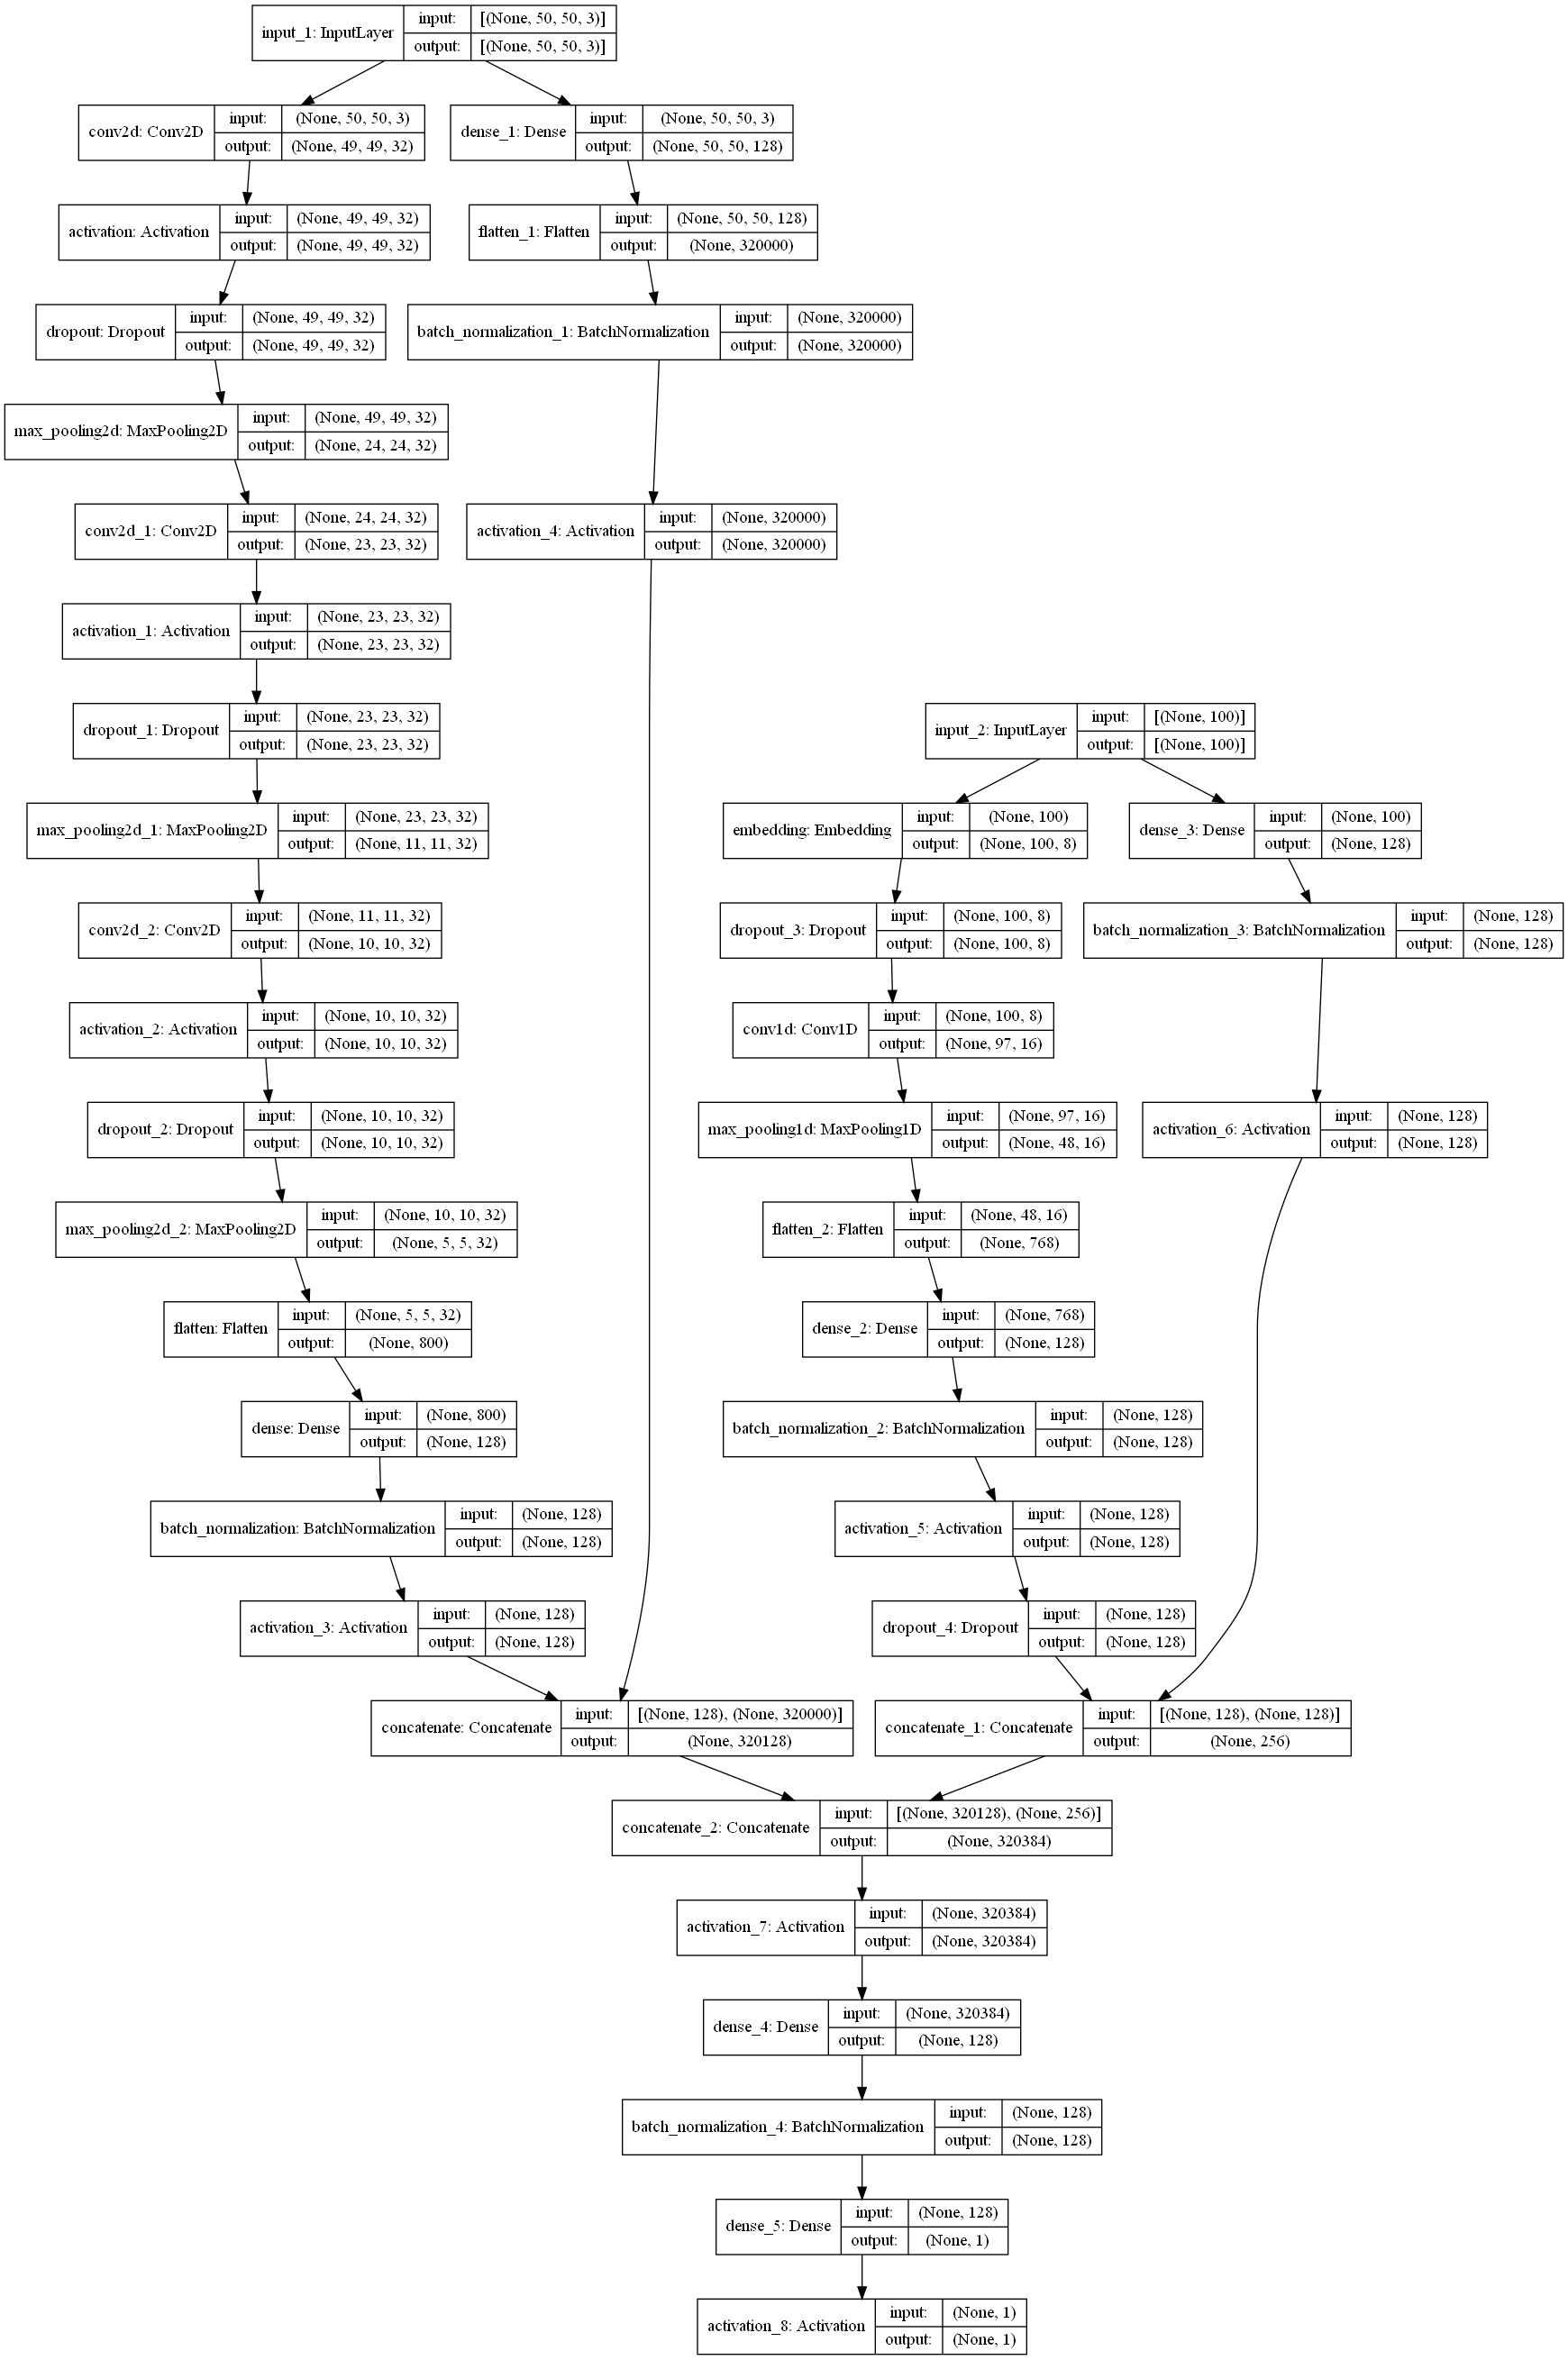

In [29]:
plot_model(model,show_shapes=True)

In [30]:
adam = Adam(learning_rate=1e-3)

model.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
history = model.fit(x=[X_train_img,X_train_seq_trunc],y=y_train_text,epochs=50,validation_data=([X_val_img,X_val_seq_trunc],y_val_text))

Epoch 1/50
1762/1762 [==============================] - 159s 86ms/step - loss: 7.1401 - accuracy: 0.5145 - val_loss: 7.1699 - val_accuracy: 0.4967
Epoch 2/50
1762/1762 [==============================] - 152s 86ms/step - loss: 6.5730 - accuracy: 0.5237 - val_loss: 6.5854 - val_accuracy: 0.5011
Epoch 3/50
1762/1762 [==============================] - 153s 87ms/step - loss: 5.0702 - accuracy: 0.5016 - val_loss: 0.6770 - val_accuracy: 0.5636
Epoch 4/50
1762/1762 [==============================] - 154s 87ms/step - loss: 0.6723 - accuracy: 0.5826 - val_loss: 0.6011 - val_accuracy: 0.7051
Epoch 5/50
1762/1762 [==============================] - 155s 88ms/step - loss: 1.0565 - accuracy: 0.6733 - val_loss: 2.3686 - val_accuracy: 0.5522
Epoch 6/50
1762/1762 [==============================] - 155s 88ms/step - loss: 0.7346 - accuracy: 0.6338 - val_loss: 0.5813 - val_accuracy: 0.7193
Epoch 7/50
1762/1762 [==============================] - 156s 88ms/step - loss: 1.1202 - accuracy: 0.6883 - val_loss: 0

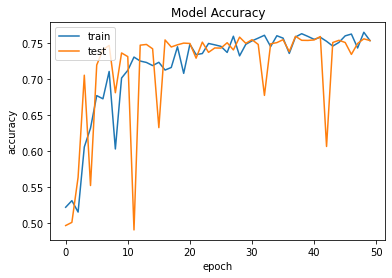

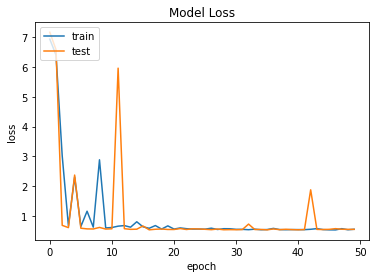

In [32]:
# Model Outputs

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()